##Third Iteration

**Changes:**
- Dropout after every layer
- Change Batch Size
- Structural change in model

**Expectations:**
- A (mostly) underfit model (since dropout is active for every layer)
- Higher accuracy

**Result**:
- Parameters: 14,708
- Epochs Run: 50
- Best Epoch: 22
- Training Accuracy: 99.46
- Validation Accuracy: 99.49


In [0]:
# Install and Import Keras
# https://keras.io/
!pip install -q keras
import keras

In [0]:
# Importing the required libraries
import numpy as np

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Add, BatchNormalization
from keras.layers import Convolution2D, MaxPooling2D
from keras.utils import np_utils
from keras.callbacks import ReduceLROnPlateau, CSVLogger, EarlyStopping, ModelCheckpoint

from keras.datasets import mnist

### Load pre-shuffled MNIST data into train and test sets

In [0]:
# Load MNIST into train and test sets
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [8]:
# Connecting Drive to save models
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


(60000, 28, 28)


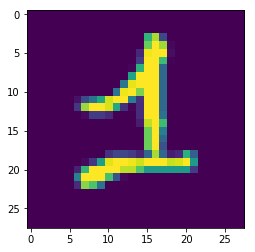

In [9]:
# Looking at sample images
print (X_train.shape)
from matplotlib import pyplot as plt
%matplotlib inline
plt.imshow(X_train[24])

In [0]:
# Defining shape of the sets
X_train = X_train.reshape(X_train.shape[0], 28, 28,1)
X_test = X_test.reshape(X_test.shape[0], 28, 28,1)

In [0]:
# Scaling down pixel values from 0-255 to 0-1
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255

In [12]:
# Inspecting labels
y_train[:10]

array([5, 0, 4, 1, 9, 2, 1, 3, 1, 4], dtype=uint8)

In [0]:
# Convert 1-dimensional class arrays to 10-dimensional class matrices
Y_train = np_utils.to_categorical(y_train, 10)
Y_test = np_utils.to_categorical(y_test, 10)

In [14]:
# Inspectingt the categorized labels
Y_train[20:30]


array([[0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]], dtype=float32)

In [28]:
# Building the infrastructure
from keras.layers import Activation
model = Sequential()
 
model.add(Convolution2D(8, 3, activation='relu', input_shape=(28,28,1), name = "C3-1")) #26
model.add(BatchNormalization(name = "BN-C3-1"))
model.add(Dropout(0.1, name = "DO-C3-1"))

model.add(Convolution2D(16, 3, activation='relu', name = "C3-2")) #24
model.add(BatchNormalization(name = "BN-C3-2"))
model.add(Dropout(0.1, name = "DO-C3-2"))

model.add(Convolution2D(16, 3, activation='relu', name = "C3-3")) #22
model.add(BatchNormalization(name = "BN-C3-3"))
model.add(Dropout(0.1, name = "DO-C3-3"))

model.add(MaxPooling2D(2, name = "MP1")) #11

model.add(Convolution2D(8, 1, activation='relu', name = "C1-1")) #11
model.add(BatchNormalization(name = "BN-C1-1"))
model.add(Dropout(0.1, name = "DO-C1-1"))

model.add(Convolution2D(16, 3, activation='relu', name = "C3-4")) #9
model.add(BatchNormalization(name = "BN-C3-4"))
model.add(Dropout(0.1, name = "DO-C3-4"))

# model.add(MaxPooling2D(2, name = "MP2")) #5

model.add(Convolution2D(10, 1, activation='relu', name = "C1-2")) #9
model.add(BatchNormalization(name = "BN-C1-2"))
model.add(Dropout(0.1, name = "DO-1-2"))

model.add(Convolution2D(16, 3, activation='relu', name = "C3-5")) #7
model.add(BatchNormalization(name = "BN-C3-5"))
model.add(Dropout(0.1, name = "DO-C3-5"))

model.add(Convolution2D(10, 7, name = "C7-1")) #1
# model.add(BatchNormalization(name = "BN-C7-1"))
# model.add(Dropout(0.1, name = "DO-C7-1"))

model.add(Flatten(name = "F"))
model.add(Activation('softmax'))

# Checking the model
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
C3-1 (Conv2D)                (None, 26, 26, 8)         80        
_________________________________________________________________
BN-C3-1 (BatchNormalization) (None, 26, 26, 8)         32        
_________________________________________________________________
DO-C3-1 (Dropout)            (None, 26, 26, 8)         0         
_________________________________________________________________
C3-2 (Conv2D)                (None, 24, 24, 16)        1168      
_________________________________________________________________
BN-C3-2 (BatchNormalization) (None, 24, 24, 16)        64        
_________________________________________________________________
DO-C3-2 (Dropout)            (None, 24, 24, 16)        0         
_________________________________________________________________
C3-3 (Conv2D)                (None, 22, 22, 16)        2320      
__________

In [0]:
from keras.optimizers import Adam
from keras.callbacks import LearningRateScheduler
def scheduler(epoch, lr):
  return round(0.003 * 1/(1 + 0.319 * epoch), 10)

In [0]:
# Compiling the model
model.compile(loss='categorical_crossentropy',
             optimizer=Adam(lr=0.003),
             metrics=['accuracy'])

In [0]:
#lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1), cooldown=0, patience=5, min_lr=0.5e-6)
#early_stopper = EarlyStopping(min_delta=0.001, patience=10)
csv_logger = CSVLogger('/content/gdrive/My Drive/EVA/P3/Try2/mnist.csv')

filepath="/content/gdrive/My Drive/EVA/P3/Try2/Iter4 - BestExp.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

In [32]:
# Training the model
model.fit(X_train,
          Y_train,
          batch_size=128,
          epochs=50,
          verbose=1,
          validation_data=(X_test, Y_test),
          callbacks=[csv_logger, checkpoint, LearningRateScheduler(scheduler, verbose=1)])

Train on 60000 samples, validate on 10000 samples
Epoch 1/50

Epoch 00001: LearningRateScheduler setting learning rate to 0.003.
60000/60000 [==============================] - 32s 536us/step - loss: 0.1839 - acc: 0.9415 - val_loss: 0.0619 - val_acc: 0.9799

Epoch 00001: val_acc improved from -inf to 0.97990, saving model to /content/gdrive/My Drive/EVA/P3/Try2/Iter4 - BestExp.hdf5
Epoch 2/50

Epoch 00002: LearningRateScheduler setting learning rate to 0.0022744503.
60000/60000 [==============================] - 20s 334us/step - loss: 0.0604 - acc: 0.9811 - val_loss: 0.0369 - val_acc: 0.9873

Epoch 00002: val_acc improved from 0.97990 to 0.98730, saving model to /content/gdrive/My Drive/EVA/P3/Try2/Iter4 - BestExp.hdf5
Epoch 3/50

Epoch 00003: LearningRateScheduler setting learning rate to 0.0018315018.
60000/60000 [==============================] - 20s 333us/step - loss: 0.0455 - acc: 0.9860 - val_loss: 0.0347 - val_acc: 0.9885

Epoch 00003: val_acc improved from 0.98730 to 0.98850, sa

In [0]:
# Loading best model from the initial training
model.load_weights("/content/gdrive/My Drive/EVA/P3/Try2/Iter4 - BestExp.hdf5")

In [0]:
# Evaluating the model on the test data
score = model.evaluate(X_test, Y_test, verbose=0)

In [36]:
# Printing test score
print(score)

[0.01888107100098714, 0.9949]
